In [2]:
import os
import pandas as pd
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time
import matplotlib.pyplot as plt
import operator
import numpy as np
import matplotlib
from wordcloud import WordCloud
import subprocess as sp
import multiprocessing as mp

# First Reading in the news.csv file as a Pandas Data Frame

In [3]:
news = pd.read_csv("news.csv")
news.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


# Clean and lemmatize title and text

Also looked at two further parameters: text length and percentage punctuation. They were also added to the classifier training.

In [34]:
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    """
    A function to tokenize and lemmatize the input text.
    """
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    tokenized_text = [word for word in tokens if word not in stopwords]
    lem_text = [wn.lemmatize(word) for word in tokenized_text]
    return lem_text

def count_punct(text):
    """
    A function that returns the % punctuation in the text
    """
    count = sum([1 for char in text if char in string.punctuation])
    try:
        return round(count/(len(text) - text.count(" ")), 3)*100
    except:
        return 0
    
pos_labels = ["NNP","VBD"]
    
def get_pos_labels(lem_text):
#     print(lem_text)
    labs = []
    for i in nltk.pos_tag(lem_text):
        try:
            labs.append(i[1])
        except:
            print(i)
            pass
    return labs

def count_pos_labels(l_list, label):
    try:
        return l_list.count(label)/len(l_list)
    except:
        return 0

def remove_empty(lem_text):
    return [i for i in lem_text if i]
    
#Adding extra columns to the data frame for text length and % punctuation
news["text_len"] = news["text"].apply(lambda x: len(x) - x.count(" "))
news["punct%"] = news["text"].apply(lambda x: count_punct(x))

#Lemmatizing the text in the data frame, for later
news["lemmatized"] = news["text"].apply(lambda x: clean_text(x))

def count_quote(text):
    return text.count("\"")

news["quotes"] = news["text"].apply(lambda x: count_quote(x))

news["pos_labels"] = news["lemmatized"].apply(lambda x: get_pos_labels(remove_empty(x)))

for l in pos_labels:
    news[l] = news["pos_labels"].apply(lambda x: count_pos_labels(remove_empty(x),l))
    


news.head()

,ID,title,text,label,text_len,punct%,lemmatized,quotes,pos_labels,PRP$,...,RBS,FW,WP$,RP,UH,PDT,POS,$,LS,sec_count
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,6221,1.7,"[Daniel, Greenfield, Shillman, Journalism, Fel...",0,"[NNP, NNP, NNP, NNP, NNP, NNP, NNP, NNP, NNP, ...",0.001351,...,0.0,0.001351,0.002703,0.000000,0.0,0.001351,0.0,0.0,0.0,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2201,2.9,"[Google, Pinterest, Digg, Linkedin, Reddit, St...",0,"[NNP, NNP, NNP, NNP, NNP, NNP, NNP, NNP, NNP, ...",0.003891,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,2121,2.0,"[US, Secretary, State, John, F, Kerry, said, M...",0,"[NNP, NNP, NNP, NNP, NNP, NNP, VBD, NNP, VB, N...",0.000000,...,0.0,0.000000,0.000000,0.003906,0.0,0.000000,0.0,0.0,0.0,2
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,2257,3.5,"[, Kaydee, King, KaydeeKing, November, 9, 2016...",0,"[NNP, NNP, NNP, NNP, CD, CD, DT, NN, VBD, NNP,...",0.003650,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1534,4.2,"[Its, primary, day, New, York, frontrunners, H...",8,"[PRP$, JJ, NN, NNP, NNP, NNS, NNP, NNP, NNP, N...",0.005128,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0


# Checking the spread of text length/puntuation % in real and fake articles

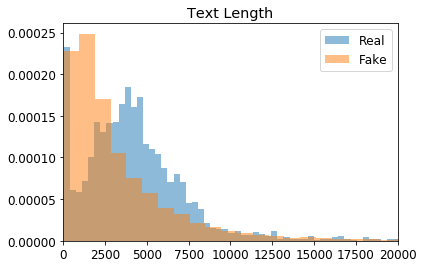

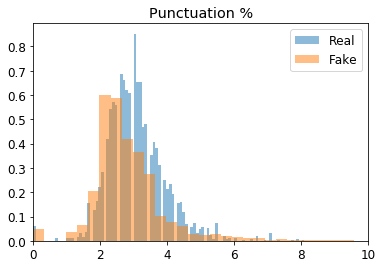

In [108]:
text_len_real = news[news["label"] == "REAL"]["text_len"]
text_len_fake = news[news["label"] == "FAKE"]["text_len"]

punct_real = news[news["label"] == "REAL"]["punct%"]
punct_fake = news[news["label"] == "FAKE"]["punct%"]

plt.hist(text_len_real,alpha=0.5,bins=100,label="Real",normed=True)
plt.hist(text_len_fake,alpha=0.5,bins=100,label="Fake",normed=True)
plt.title("Text Length")
plt.legend()
plt.xlim(0,20000)
plt.show()

plt.hist(punct_real,alpha=0.5,bins=100,label="Real",normed=True)
plt.hist(punct_fake,alpha=0.5,bins=100,label="Fake",normed=True)
plt.title("Punctuation %")
plt.legend()
plt.xlim(0,10)
plt.show()

# Split into Train and Test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(news[["text","punct%","text_len","quotes","sec_count"]+pos_labels], news["label"],test_size=0.2)

# TFIDF Vectorising

In [36]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train["text"])

tfidf_train = tfidf_vect_fit.transform(X_train["text"])
tfidf_test = tfidf_vect_fit.transform(X_test["text"])

X_train_vect = pd.concat([X_train[['text_len', 'punct%','quotes','sec_count']+pos_labels].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['text_len', 'punct%',"quotes",'sec_count']+pos_labels].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.columns = ["text_len","punct%","quotes",'sec_count']+pos_labels+tfidf_vect.get_feature_names()
X_test_vect.columns = ["text_len","punct%","quotes",'sec_count']+pos_labels+tfidf_vect.get_feature_names()

X_train_vect.head()

,text_len,punct%,quotes,sec_count,NNP,VBD,,0,00,000,...,תוצאה,תחל,תיירות,תנותק,תעודת,תתרכז,القادمون,عربي,ยงade,⅔
0,2146,2.7,2,0,0.174721,0.085502,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3377,4.4,21,0,0.167476,0.094660,0.023187,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1619,4.1,2,0,0.366667,0.042857,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,271,10.7,0,0,0.580645,0.032258,0.077846,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6346,2.2,0,1,0.157124,0.053262,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train Random Forest Classifier

In [37]:
rf = RandomForestClassifier(n_estimators=500, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='REAL', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 72.485 / Predict time: 2.032 ---- Precision: 0.913 / Recall: 0.908 / Accuracy: 0.911


Classifier takes very little time to train (even on only 4 cores) and shows good performance accross the board!

# Looking at the features which distinguish between fake and real articles

First taking out the 50 most important features

In [66]:
feats = {}
for n,i in zip(X_train_vect.columns,rf_model.feature_importances_):
    feats[i] = n
    
k_sorted = sorted(feats.keys(),reverse=True)
top_50 = [feats[i] for i in k_sorted[0:52] if feats[i] not in ["text_len","punct%"]]

In [64]:
def count_word_norm(word):
    """
    A function to count the number of times a particular lemmatized term appears in real and fake articles
    """
    d_counts = {"REAL":0,"FAKE":0}
    for row in news[["lemmatized","label"]].iterrows():
        if row[1]["label"] == "REAL":
            d_counts["REAL"] += row[1]["lemmatized"].count(word)/len(row[1]["lemmatized"])
        else:
            d_counts["FAKE"] += row[1]["lemmatized"].count(word)/len(row[1]["lemmatized"])
    return d_counts

In [73]:
words = []
real = []
fake = []

for word in top_50:
    counts = count_word_norm(word)
    words.append(word)
    real.append(counts["REAL"])
    fake.append(counts["FAKE"])

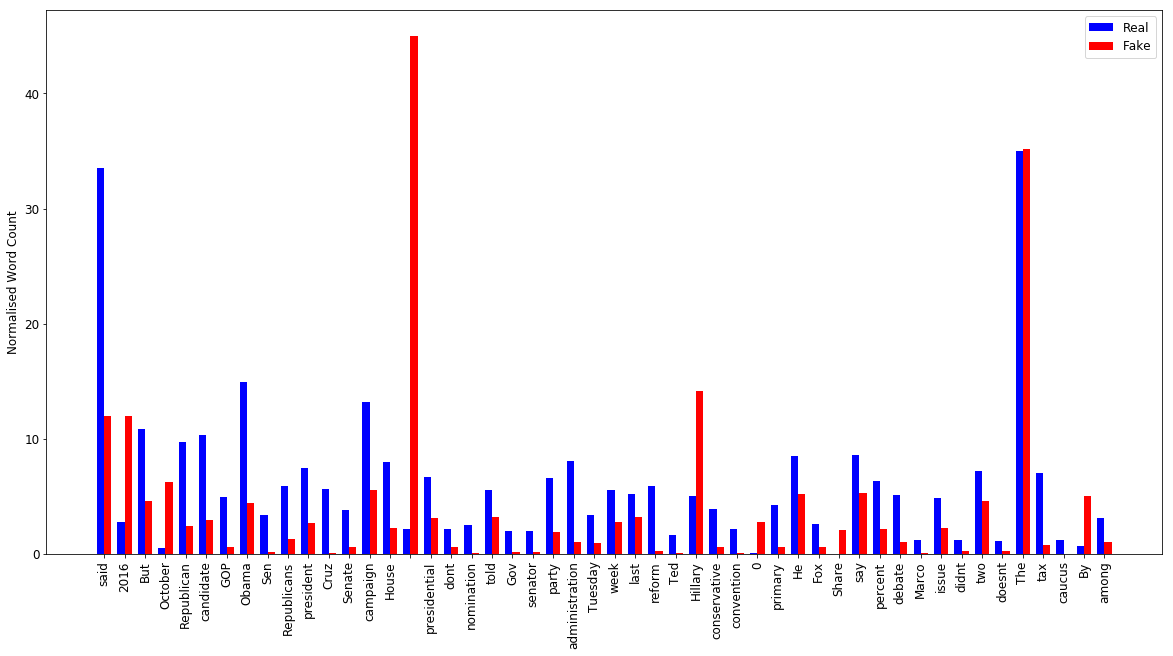

In [75]:
font = {'family' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

N=len(words)
ind = np.arange(N)
width = 0.35

f,ax = plt.subplots(figsize=(20,10))

rects1 = ax.bar(ind,real,width=width,color='b',label="Real")
rects2 = ax.bar(ind+width,fake,width=width,color='r',label="Fake")

ax.set_xticks(ind+width/2)
ax.set_xticklabels(words,rotation=90)

ax.set_ylabel("Normalised Word Count")

plt.legend()

plt.show()

# Inferences from these feature importances

## Referring to sources
The most important feature in the model is the word "said", this is much more populated in real articles. This could infer that real articles refer more often to other sources. To test this I looked further at whether real articles contained more quotation marks. The histogram (below) shows that indeed real articles do appear to contain more quotation marks. I then incorporated this into my classifier training and it showed marginal increase in performance.

## Use of titles
Names appear to be quite polarising, "Obama" appears more in real articles (he was president at the time this data was taken) and "Hillary" is mentioned much more in fake articles. Hillary Clinton was obviously a very important figure at the time, so I thought this may be due to to the real articles referring to her more often as "Secretary Clinton" or similar, whereas fake news may prefer "Hillary" which has been used more derogatively. So I pulled out how many times words relating to "secretary" were used in articles. This also seemed slightly more skewed towards real artlicles (though they are also more likely to not use it at all). I included it in my model and again a small performance increase was seen.

## Grammatical errors
The number of empty strings in fake articles is substantially higher than in real articles, these likely arise from gramatical errors. Currently I'm trying to find a useable tool to count grammatical errors in all of the articles, once I've found one I'll likely update this picture.

In [79]:
def count_quote(text):
    return text.count("\"")

news["quotes"] = news["text"].apply(lambda x: count_quote(x))

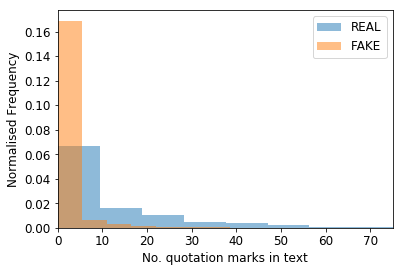

In [127]:
real_quotes = news[news["label"]=="REAL"]["quotes"]
fake_quotes = news[news["label"]=="FAKE"]["quotes"]

plt.hist(real_quotes,alpha=0.5,bins=20,label="REAL",normed=True)
plt.hist(fake_quotes,alpha=0.5,bins=20,label="FAKE",normed=True)
plt.xlabel("No. quotation marks in text")
plt.ylabel("Normalised Frequency")
plt.xlim(0,75)
plt.legend()
plt.show()

In [6]:
def count_secretary(text):
    return text.lower().count("secretary") + text.lower().count("sec.") + text.lower().count("sec ")

news["sec_count"] = news["text"].apply(lambda x: count_secretary(x))

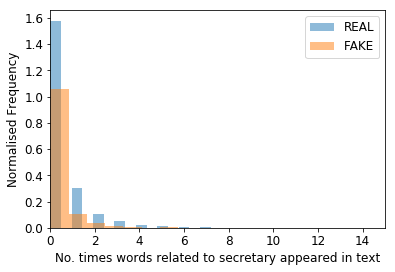

In [129]:
real_quotes = news[news["label"]=="REAL"]["sec_count"]
fake_quotes = news[news["label"]=="FAKE"]["sec_count"]

plt.hist(real_quotes,alpha=0.5,bins=50,label="REAL",normed=True)
plt.hist(fake_quotes,alpha=0.5,bins=50,label="FAKE",normed=True)
plt.xlabel("No. times words related to secretary appeared in text")
plt.ylabel("Normalised Frequency")
plt.xlim(0,15)
plt.legend()
plt.show()

# Wordclouds for real and fake articles

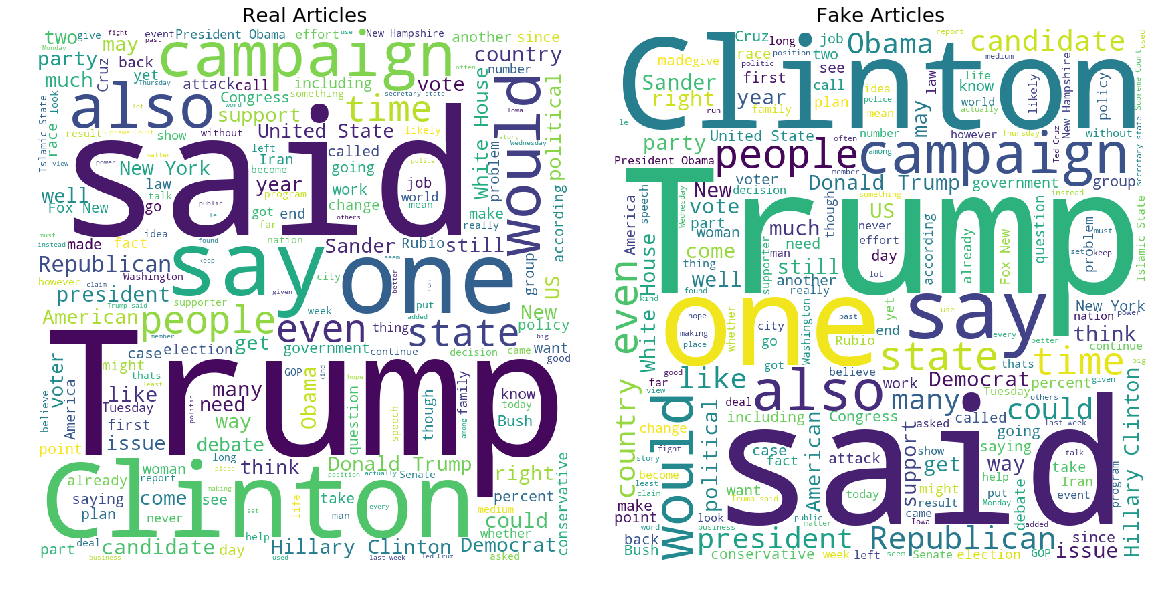

In [194]:
real_text = news[news["label"] == "REAL"]["lemmatized"]
fake_text = news[news["label"] == "FAKE"]["lemmatized"]

real_string = " ".join([" ".join(i) for i in real_text])
fake_string = " ".join([" ".join(i) for i in real_text])

wordcloud_real = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(real_string) 

wordcloud_fake = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(fake_string)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8),sharex=True, facecolor=None)
ax1.imshow(wordcloud_real) 
ax2.imshow(wordcloud_fake)

ax1.axis("off")
ax2.axis("off")

ax1.set_title("Real Articles",fontsize=20)
ax2.set_title("Fake Articles",fontsize=20)

plt.tight_layout(pad = 0) 
  
# # plot the WordCloud image                        
# plt.figure(figsize = (8, 8), facecolor = None) 
# plt.imshow(wordcloud) 
# plt.axis("off") 
# plt.tight_layout(pad = 0) 
  
plt.show() 

No real clear insights from these, Trump and Clinton are highly populated in both.

# Pos tagging
NLTK offers pos tagging to distiguish between word types. The bar chart below shows normalised differences in the amount of various word types in the lemmatized text. More positive = higher in real articles, more negative = higher in false articles (see https://tinyurl.com/y7vwfu4a for info on pos tags).

From this the main insights appear to be that fake news appears to contain more proper nouns (NNP), this may be due to their previously stated indefference to the position of many figures (e.g. Hillary or Secretary Clinton).

Real news appears to contain substantially more past tense verbs(VBD), suggests that they are more reflective on past events? Suggest fake news could be more doctrinarial?

Including NNP and VBD into the RF model had no real effect on Precision and accuracy but did provide a slight increase in recall.

Including all pos tags decreased RF model performance.

In [17]:
pos_real = []
pos_fake = []

for row in news[["lemmatized","label"]].iterrows():
    try:
        if row[1]["label"] == "REAL":
            pos_real.append(nltk.pos_tag(row[1]["lemmatized"]))
        else:
            pos_fake.append(nltk.pos_tag(row[1]["lemmatized"]))
    except:
        pass

In [28]:
d_pos_real = {}

for p in pos_real:
    for pp in p:
        if pp[1] not in d_pos_real.keys():
            d_pos_real[pp[1]] = 1
        else:
            d_pos_real[pp[1]] += 1
            
d_pos_fake = {}

for p in pos_fake:
    for pp in p:
        if pp[1] not in d_pos_fake.keys():
            d_pos_fake[pp[1]] = 1
        else:
            d_pos_fake[pp[1]] += 1

for k in d_pos_fake.keys():
    if k not in d_pos_real.keys():
        d_pos_real[k] = 0
        
for k in d_pos_real.keys():
    if k not in d_pos_fake.keys():
        d_pos_fake[k] = 0

In [29]:
d_pos_real_norm = {k:v/sum(d_pos_real.values()) for k,v in d_pos_real.items()}
d_pos_fake_norm = {k:v/sum(d_pos_fake.values()) for k,v in d_pos_fake.items()}
d_pos_diff_norm = {k:d_pos_real_norm[k]-d_pos_fake_norm[k] for k in d_pos_real_norm.keys()}

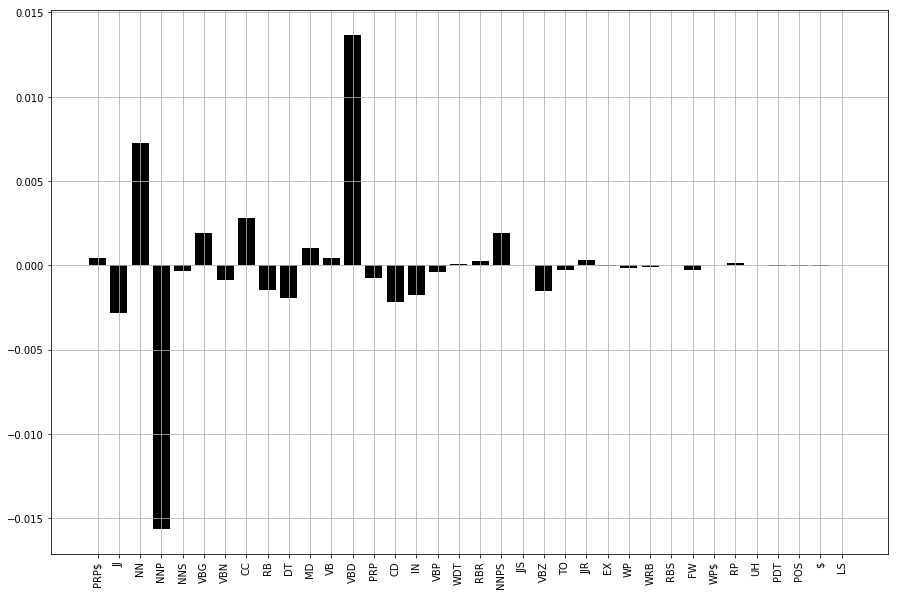

In [33]:
plt.figure(figsize=(15,10))
plt.bar(range(len(d_pos_diff_norm)), list(d_pos_diff_norm.values()), align='center',color='k')
plt.xticks(range(len(d_pos_diff_norm)), list(d_pos_diff_norm.keys()),rotation=90)
plt.grid()
plt.show()

# Summary

1. I read in the fake news csv file (from Data Flair: https://tinyurl.com/shqhenh) into a pandas DataFrame.
2. I added in % punctuation and text length columns.
3. I split into training and test sets (80/20 split).
4. I used a Tf-IDF vectorizer with an analyzer function to tokenise and lemmatize the text.
5. Using the tokenized data I trained a Random Forest with 500 trees.
6. I took out the most important features, looked at which words were having the greatest impact, using this information I included columns with the number of quotation marks and the number of times the word "Secretary"/similar was used.
7. Repeated steps 3-5, improved the performance of my classifier.
8. Used NLTK pos tagging to look at the types of words most commonly seen in real and fake articles. Added columns for proportion of text which is a past tense verb and pronoun.
9. Repeated steps 3-5, improved the performance of my classifier.

I also intend to look more into checking quanifiying grammatical errors in the texts to see if there is a quantifiable error rate difference between real and fake articles.

I learned a lot of this from the NLP with Python for Machine Learning Essential Training course on LinkedIn Learning (https://tinyurl.com/ybweduvt).

This was my first proper attempt at my own machine learning problem, so I'd be interested in any suggestions etc!